# Accessing data as JSON via `yodapy`

This notebook shows an example of json request using `yodapy` for OOI data.

## Getting Started
    - Create a user account on ooinet.oceanobservatories.org, or use the CILogon button with an academic or Google account.
    - Log in
    - Navigate to the drop down menu screen in the top-right corner menu
    - Click on the "User Profile" element of the drop down.
    - Copy and save the following data from the user profile: API Username and API Token. The API Username is similar to “OOIAPI-QTULEV9STCAS55”. The API Token is similar to “YXP2Q2W4SOP”.

In [1]:
%matplotlib inline
import datetime
import re

import pandas as pd

import matplotlib as mp
import matplotlib.pyplot as plt

import yodapy as yp
from yodapy.datasources import OOI
from yodapy.utils import set_credentials_file
from yodapy.utils.parser import seconds_to_date

In [2]:
print('Versions Used:')
print(f'Yodapy version: {yp.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'Matplotlib version: {mp.__version__}')

Versions Used:
Yodapy version: 0.2.1-beta.1
Pandas version: 0.23.1
Matplotlib version: 2.2.2


The API will need your API-USER and API-TOKEN information from your OOI account. We can use the `set_credentials_file` function in `utils` to set our credential.

In [3]:
set_credentials_file(data_source='ooi', username='API-USER', token='API-TOKEN')

In [4]:
ooi = OOI()

In this example we will request information and data from the Cabled Axial Seamount ASHES Vent Field (RS03ASHS) - Medium-Power JBox (MJ03B) - Diffuse Vent Fluid 3-D Temperature Array (07-TMPSFA301) sensor. For this example, we will request all data between 2017-09-04T17:54:58.050Z and 2017-11-04T23:54:58.050Z.

First, we will filter the instruments available within OOI to get what we want

In [5]:
asset = ooi.filter(region='Cabled Array', site='Axial Seamount ASHES Vent Field', instrument='Diffuse Vent Fluid 3-D Temperature Array')

In [6]:
asset.view_instruments()

,reference_designator,name,start_depth,end_depth,current_status,preferred_stream,preferred_parameter,location
1258,RS03ASHS-MJ03B-07-TMPSFA301,Diffuse Vent Fluid 3-D Temperature Array,1552.0,1552.0,,tmpsf_sample,2630,Located Off Jbox


Next, let's send the data request. Notice the addition of limit=1000 below. This tells the system that we want the data to be returned as instantaneous JSON response, instead of asynchronously delivered as NetCDF files onto the THREDDS server.

In [7]:
stdt = '2017-09-04T17:54:58.050Z'
enddt = '2017-09-11T23:54:58.050Z'

asset.request_data(
    begin_date=stdt,
    end_date=enddt,
    data_type='json',
    limit=1000, 
    provenance=False
)

<Data Source: OOI>

In [8]:
results = asset.raw()

There should be only 1 result for the instrument

In [9]:
len(results)

1

Now let's extract the data

In [10]:
data = results[0]

All the data points are now contained in the data variable object. Since we aren't dealing with a NetCDF file, we won't be using the xarray package, and will need to manually convert the ntp seconds to date time by using yodapy's `seconds_to_date` function from `yodapy.utils.parsers`. We will now convert data points to pandas dataframe and convert ntp seconds to date.

In [11]:
df = pd.DataFrame.from_records(data).copy()
df.loc[:, 'time'] = df['time'].apply(lambda t: seconds_to_date(t))

Now let's plot the data for temperatures

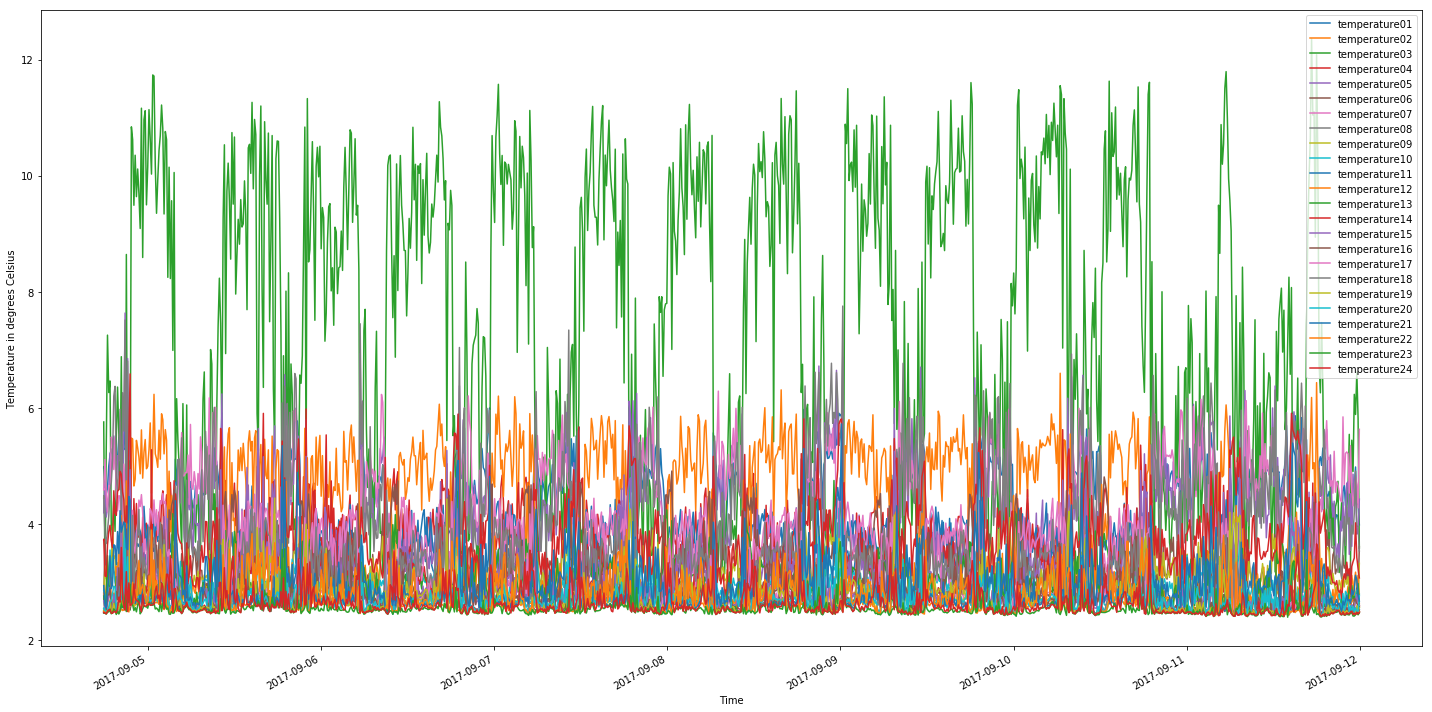

In [12]:
temperatures = list(filter(lambda x: re.match(r'temperature\d+$', x), df.columns))
fig, ax = plt.subplots(1, figsize=(20, 10))

df.plot(ax=ax, x='time', y=temperatures)
plt.ylabel('Temperature in degrees Celsius')
plt.xlabel('Time')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()